
# Логистическая регрессия




In [1]:

# Импорты
import math
import numpy as np
import matplotlib.pyplot as plt



## Данные: простой синтетический пример

Сгенерируем две «облака» точек в 2D, частично пересекающиеся. Это классический кейс для логистической регрессии.


In [2]:

# Генерируем двухклассовые данные в 2D
n_per_class = 200
cov = [[1.0, 0.4],
       [0.4, 1.0]]

mean0 = np.array([-2.0, -1.0])
mean1 = np.array([ 2.0,  1.5])

X0 = np.random.multivariate_normal(mean0, cov, size=n_per_class)
X1 = np.random.multivariate_normal(mean1, cov, size=n_per_class)

X = np.vstack([X0, X1])           # форма (N, 2)
y = np.hstack([np.zeros(n_per_class), np.ones(n_per_class)])  # (N,)

# Добавим столбец единиц для свободного члена b0
X_ext = np.hstack([np.ones((X.shape[0], 1)), X])  # (N, 1+2)

X.shape, X_ext.shape, y.shape


((400, 2), (400, 3), (400,))

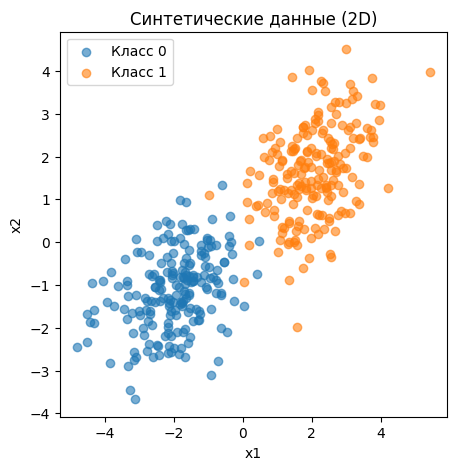

In [3]:

# Визуализируем точки (один график, без указания цветов)
fig, ax = plt.subplots(figsize=(5, 5))
mask1 = (y == 1)
ax.scatter(X[~mask1, 0], X[~mask1, 1], label="Класс 0", alpha=0.6)
ax.scatter(X[mask1, 0],  X[mask1, 1],  label="Класс 1", alpha=0.6)
ax.set_title("Синтетические данные (2D)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.show()



## Реализация логистической регрессии


In [4]:

def sigmoid(z):
  # Стабильная сигмоида
  # z может быть вектором/матрицей
  return 1.0 / (1.0 + np.exp(-z))

def predict_proba(X_ext, b):
  # X_ext: (N, d+1) с единичным столбцом
  # b: (d+1, )
  z = X_ext @ b
  return sigmoid(z)

def log_loss(y_true, p_pred, eps=1e-12):
  # Численно стабильная log-loss
  p = np.clip(p_pred, eps, 1.0 - eps)
  return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

def accuracy(y_true, y_pred_labels):
  return np.mean(y_true == y_pred_labels)



### Обучение (градиентный спуск)

Будем минимизировать log-loss, обновляя \(b\).  
Порог классификации — 0.5 (можно менять).


In [5]:

# Инициализация параметров
N, d_plus_1 = X_ext.shape
b = np.zeros(d_plus_1)

alpha = 0.1  # скорость обучения
epochs = 500  # число итераций
loss_history = []

for epoch in range(epochs):
  p = predict_proba(X_ext, b)  # (N,)
  loss = log_loss(y, p)
  loss_history.append(loss)

  # Градиент: (d+1,)
  grad = (X_ext.T @ (p - y)) / N
  b -= alpha * grad

b, loss_history[-1]


(array([-0.18908674,  2.3456875 ,  1.25218641]),
 np.float64(0.03425983127336508))

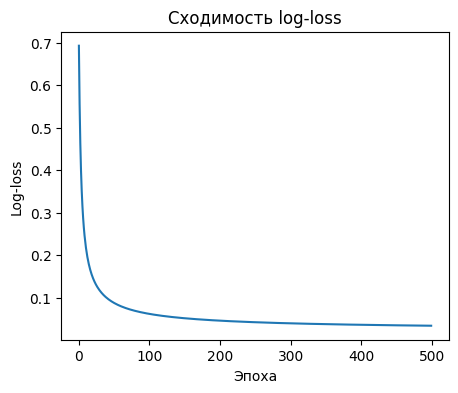

In [6]:

# График сходимости
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(loss_history)
ax.set_title("Сходимость log-loss")
ax.set_xlabel("Эпоха")
ax.set_ylabel("Log-loss")
plt.show()



### Качество и граница решения

Посчитаем точность на тех же данных и визуализируем линию \(p=0.5\) — это линейная граница в пространстве признаков.


Accuracy (на обучающих данных): 0.990


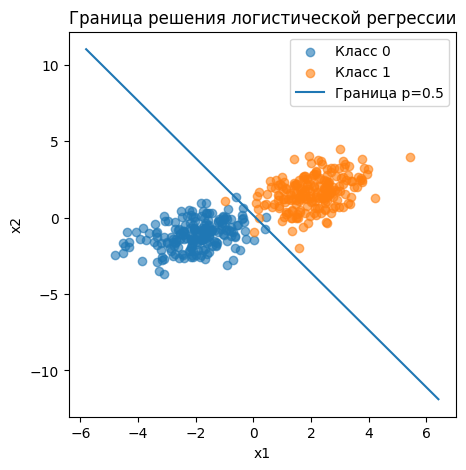

In [7]:

# Предсказания и accuracy
p = predict_proba(X_ext, b)
y_hat = (p >= 0.5).astype(int)
acc = accuracy(y, y_hat)

print(f"Accuracy (на обучающих данных): {acc:.3f}")

# Визуализация границы (p=0.5): b0 + b1*x1 + b2*x2 = 0  =>  x2 = -(b0 + b1*x1)/b2
fig, ax = plt.subplots(figsize=(5, 5))
mask1 = (y == 1)
ax.scatter(X[~mask1, 0], X[~mask1, 1], label="Класс 0", alpha=0.6)
ax.scatter(X[mask1, 0],  X[mask1, 1],  label="Класс 1", alpha=0.6)

if abs(b[2]) > 1e-8:
  x1_line = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
  x2_line = -(b[0] + b[1]*x1_line) / b[2]
  ax.plot(x1_line, x2_line, label="Граница p=0.5")

ax.set_title("Граница решения логистической регрессии")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.show()



## Численный мини‑пример

Повторим пример из презентации. Обучим \(b_0, b_1\) градиентным спуском.


In [8]:

X_small = np.array([[1.0],
                    [2.0],
                    [3.0]])
y_small = np.array([0.0, 0.0, 1.0])

# Добавим столбец единиц
X_small_ext = np.hstack([np.ones((X_small.shape[0], 1)), X_small])

b_small = np.zeros(2)  # [b0, b1]
alpha_small = 0.1
epochs_small = 500
loss_hist_small = []

for ep in range(epochs_small):
  p_small = predict_proba(X_small_ext, b_small)
  loss_small = log_loss(y_small, p_small)
  loss_hist_small.append(loss_small)
  grad_small = (X_small_ext.T @ (p_small - y_small)) / X_small_ext.shape[0]
  b_small -= alpha_small * grad_small

print("Коэффициенты (после обучения):", b_small)
print("Последний log-loss:", loss_hist_small[-1])

# Покажем вероятности
p_final = predict_proba(X_small_ext, b_small)
for xi, pi in zip(X_small.ravel(), p_final):
  print(f"x={xi:.1f} -> p={pi:.3f}")


Коэффициенты (после обучения): [-4.04303476  1.67647543]
Последний log-loss: 0.2713150768920402
x=1.0 -> p=0.086
x=2.0 -> p=0.334
x=3.0 -> p=0.728
